# Model Evaluation Notebook

# evaluate_model.ipynb


This notebook evaluates a pretrained classifier on validation and test datasets. It computes overall accuracy and plots confusion matrices for each dataset.

## 1. Imports and Setup

In [1]:

# %%
import os
import sys
import yaml
import random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from safetensors.torch import load_file

# Custom modules (adjust the paths as necessary)
project_root = "/project_ghent/Mostafa/ActivityRecognition/DistInference"
project_root2 = "/project_ghent/Mostafa/ActivityRecognition/DistInference/src/DistInference"
os.chdir(project_root)
sys.path.append(project_root)
sys.path.append(project_root2)

from DistInference.models import My_Model
from DistInference.general_utils import load_config
from DistInference.get_fold_dataloaders import get_dataloaders_from_config

/project_ghent/Mostafa/ActivityRecognition/DistInference/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Set Seed for Reproducibility


In [2]:
def set_seed(seed):
    """
    Set the seed for all relevant libraries to ensure reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

config = load_config("/project_ghent/Mostafa/ActivityRecognition/DistInference/config.yaml")
seed = config.get('training', {}).get('seed', 42)  # Default to 42 if not specified
set_seed(seed)


## 3. Load Configuration

In [3]:
config_path = "/project_ghent/Mostafa/ActivityRecognition/DistInference/config.yaml"
config = load_config(config_path)

## 6. Load the Pretrained Model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Initialize the model
model = My_Model(config)

# Path to the pretrained model weights
model_weights_path = "/project_ghent/Mostafa/ActivityRecognition/DistInference/trained_model/model.safetensors"
model_weights_path = "/project_ghent/Mostafa/ActivityRecognition/DistInference/trained_model/20250101_054503/model.safetensors"

# Load the state_dict
state_dict = load_file(model_weights_path)

# Update the model with loaded weights
model.load_state_dict(state_dict)

# Move the model to the appropriate device
model.to(device)

# Set the model to evaluation mode
model.eval()

print("Model loaded and set to evaluation mode.")

Using device: cuda
GPU: NVIDIA A40
Backbone 'resnet50' outputs 2048 features.
Model loaded and set to evaluation mode.


## 7. Prepare Data Loaders

In [5]:
# Function to create data loaders
def get_evaluation_dataloaders(config_path):
    """
    Retrieves validation and test dataloaders along with their datasets.

    Args:
        config_path (str): Path to the configuration file.

    Returns:
        val_loader (DataLoader): DataLoader for the validation set.
        test_loader (DataLoader): DataLoader for the test set.
        val_dataset (Dataset): Validation dataset.
        test_dataset (Dataset): Test dataset.
    """
    # Retrieve all dataloaders; we only need val and test
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, fold_index = get_dataloaders_from_config(config_path)
    return val_loader, test_loader, val_dataset, test_dataset

# Get validation and test loaders
val_loader, test_loader, val_dataset, test_dataset = get_evaluation_dataloaders(config_path)

print("Data loaders for validation and test datasets are ready.")

# %% [markdown]
# ## 8. Define Metrics and Evaluation Function

# %%
def compute_metrics(preds, labels, num_classes):
    """
    Compute accuracy and confusion matrix.

    Args:
        preds (list or np.array): Predicted labels.
        labels (list or np.array): True labels.
        num_classes (int): Number of classes.

    Returns:
        accuracy (float): Accuracy score.
        cm (np.array): Confusion matrix.
    """
    # Compute accuracy
    accuracy = np.mean(np.array(preds) == np.array(labels))
    
    # Compute confusion matrix
    cm = confusion_matrix(labels, preds, labels=list(range(num_classes)))
    
    return accuracy, cm

def evaluate_model(model, dataloader, device, num_classes):
    """
    Evaluate the model on a given dataloader.
    Returns accuracy and confusion matrix.

    Args:
        model (nn.Module): The pretrained model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        device (torch.device): Device to run the evaluation on.
        num_classes (int): Number of classes.

    Returns:
        accuracy (float): Accuracy score.
        cm (np.array): Confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Batch is a list of two tensors: [inputs, labels]
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            outputs = model(inputs)
            
            # Access 'logits' from the model's output
            if isinstance(outputs, dict) and 'logits' in outputs:
                logits = outputs['logits']
            else:
                raise KeyError("Model output does not contain 'logits' key.")
            
            predictions = torch.argmax(logits, dim=-1)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy, cm = compute_metrics(all_preds, all_labels, num_classes)
    return accuracy, cm


{'folds_json': 'five_folds.json', 'fold_index': 0, 'train_split_percentage': 0.8, 'batch_sizes': {'train': 512, 'validation': 8, 'test': 1}, 'normalization': 'none', 'force_dim': 314, 'shuffle': {'train': True, 'validation': False, 'test': False}, 'additive_noise_std': {'train': 0.0, 'validation': 0.0, 'test': 0.0}, 'num_workers': {'train': 4, 'validation': 0, 'test': 0}, 'stft': {'window_size': 128, 'overlap': 64}, 'model': {'name': 'resnet50', 'num_classes': 6, 'input_channels': 1, 'learn_order_of_importance': True, 'max_p': 1}, 'training': {'max_steps': 10000.0, 'learning_rate': '8e-4', 'weight_decay': '1e-2', 'logging_steps': 10, 'save_steps': 100, 'evaluation_strategy': 'steps', 'eval_steps': 100, 'save_total_limit': 3}, 'inference': {'noise_level': 0.0}}
Data loaders for validation and test datasets are ready.


/project_ghent/Mostafa/ActivityRecognition/DistInference/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 9. Evaluate on Validation and Test Sets

In [6]:
num_classes = config['model']['num_classes']

# Evaluate on Validation Set
val_accuracy, val_cm = evaluate_model(model, val_loader, device, num_classes)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on Test Set
test_accuracy, test_cm = evaluate_model(model, test_loader, device, num_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.9321
Test Accuracy: 0.9040


## 10. Plot Normalized Confusion Matrix

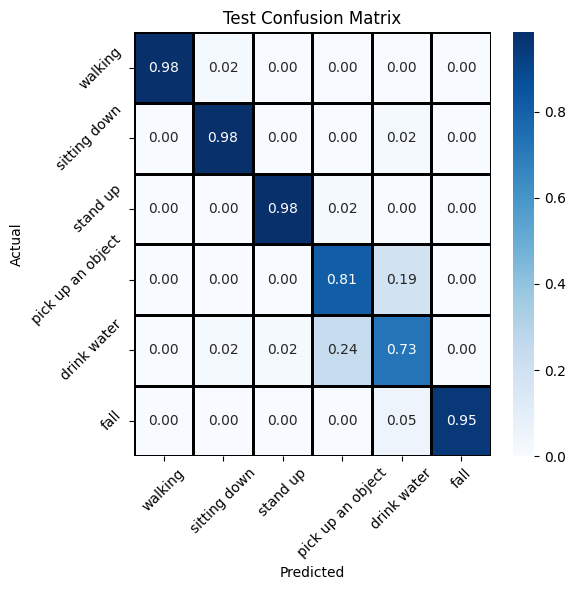

In [8]:
def plot_and_save_normalized_confusion_matrix(cm, class_names, title, filename, line_width=1):
    """
    Plot, display, and save the normalized confusion matrix with configurable line width.

    Args:
        cm (np.array): Confusion matrix.
        class_names (list): List of class names.
        title (str): Title for the plot.
        filename (str): Filename to save the plot.
        line_width (float): Width of the lines between blocks in the heatmap.
    """
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 6))
    sns.heatmap(
        cm_normalized, annot=True, fmt='.2f', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names,
        linecolor='black', linewidths=line_width
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot as an image
    plt.savefig(filename)
    plt.show()

# Label mapping for readability
label_map = {
    0: 'walking',
    1: 'sitting down',
    2: 'stand up',
    3: 'pick up an object',
    4: 'drink water',
    5: 'fall'
}

# Get class labels for the confusion matrix
class_names = [label_map[i] for i in range(len(label_map))]

# Example usage:
# Plot and save Normalized Test Confusion Matrix
plot_and_save_normalized_confusion_matrix(
    test_cm, class_names, "Test Confusion Matrix", "notebooks/test_confusion_matrix.png"
)
